# Wagen Pendel Systemidentification mit SINDy
##  Linearisierte DGL
## autonomes System

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint
from sklearn.linear_model import Lasso

import pysindy as ps
import pickle
import random



### Systemgleichungen


In [2]:
system_read = pickle.load(open("wagen_pendel_a.p","rb"))
%time rhs = system_read.create_simfunction()


Wall time: 39 ms


### Trainingsdaten generieren

In [31]:
# Noise on/off?
noise = False
eps = .00001 # Noise level

tt = np.linspace(0, 5, 1000)
data_sequence = []
for i in range(0,10):
    random.seed(i)
    xx0=[random.uniform(-3,3),random.uniform(-3,3),random.uniform(-3,3),random.uniform(-3,3)]
    data_set = odeint(rhs, xx0, tt) 
    if noise:
        data_set = data_set + np.random.normal(scale=eps, size=data_set.shape)
    data_sequence.append(data_set)

x_train = data_sequence

# print(data_sequence)

### Modellparameter einstellen

In [24]:
library_functions = [
    lambda x : x,
    lambda x : np.sin(x),
    lambda x : np.cos(x)
]
library_function_names = [
    lambda x : x,
    lambda x : 'sin(' + x + ')',
    lambda x : 'cos(' + x + ')',

]
custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

differentiation_method = ps.FiniteDifference(order=2)
# feature_library = ps.PolynomialLibrary(degree=9)
# feature_library = ps.FourierLibrary() 
feature_library = custom_library
# feature_library = ps.IdentityLibrary()

optimizer = ps.SR3(threshold=0.002)
# optimizer = ps.STLSQ(threshold=0.2)

### fit model

In [32]:



model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["phi", "x", "phidot","xdot"]
)
dt= 0.005
model.fit(x_train, t=dt, multiple_trajectories=True)
model.print()

phi' = 1.001 phidot
x' = 1.001 xdot
phidot' = -36.513 sin(phi)
xdot' = 0.000


### zu erwarten:
```
phi'    = 1 * phidot   
x'      = 1 * xdot  
phidot' = -36,482 * sin(phi) 
xdot'   = 0
```

In [6]:
t_test = np.linspace(0, 5, 1000)
random.seed(12)
x0_test = [random.uniform(-3,3),random.uniform(-3,3),random.uniform(-3,3),random.uniform(-3,3)]
x_test = odeint(rhs, x0_test, t_test)


In [7]:
# # Compare SINDy-predicted derivatives with finite difference derivatives
print('Model score: %f' % model.score(x_test, t=dt))

Model score: -1.012305


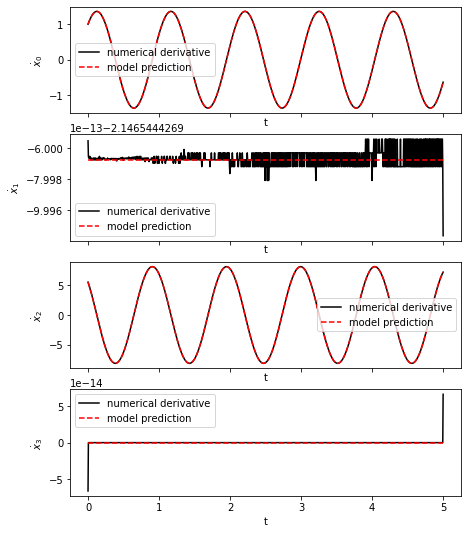

In [8]:
# Predict derivatives using the learned model
x_dot_test_predicted = model.predict(x_test)  

# Compute derivatives with a finite difference method, for comparison
x_dot_test_computed = model.differentiate(x_test, t=dt)
#t_test = np.linspace(0, 15, 3000)


fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))

for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_dot_test_computed[:, i],
                'k', label='numerical derivative')
    axs[i].plot(t_test, x_dot_test_predicted[:, i],
                'r--', label='model prediction')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$\dot x_{}$'.format(i))

fig.show()

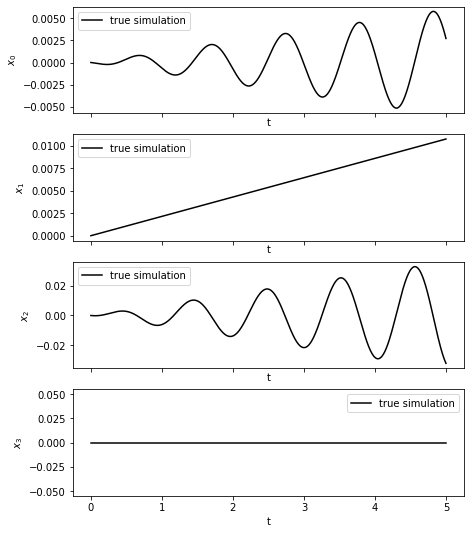

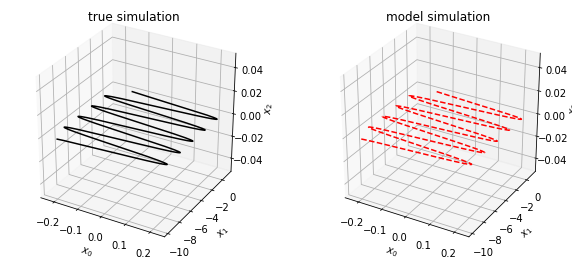

In [9]:
# Evolve the new initial condition in time with the SINDy model

t_evolve = np.linspace(0, 5, 1000)
x_test_sim = model.simulate(x0_test, t_evolve)

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_test[:, i]-x_test_sim[:, i], 'k', label='true simulation')
    #axs[i].plot(t_evolve, x_test_sim[:, i], 'r--', label='model simulation')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i))

fig = plt.figure(figsize=(10, 4.5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(x_test[:, 0], x_test[:, 1],  'k')
ax1.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='true simulation')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(x_test_sim[:, 0], x_test_sim[:, 1], 'r--')
ax2.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='model simulation')

fig.show()

[[ 1.          1.          0.          0.        ]
 [ 0.99961591  1.         -0.15347737  0.        ]
 [ 0.99846383  1.         -0.30687898  0.        ]
 ...
 [-0.99972565  1.         -0.12974074  0.        ]
 [-0.99999092  1.          0.02374162  0.        ]
 [-0.99948801  1.          0.17721226  0.        ]]


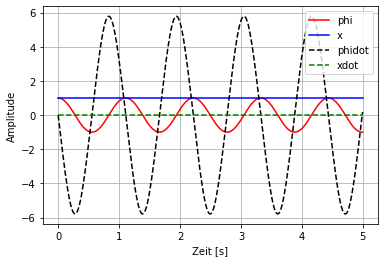

In [10]:
g = 9.81
s2 = 0.26890449
def ori_model_func(x, t):
    return[
        1.001*x[2],
        1.001*x[3],
        -g/s2*np.sin(x[0]),
        0
    ]
t_ori_model = np.arange(0, 5, dt)
x0_ori_model = [1,1,0,0]

ori_model_data = odeint(ori_model_func, x0_ori_model, t_ori_model)
print(ori_model_data)



plt.plot(t_ori_model, ori_model_data[:,0], color= 'red', label="phi")
plt.plot(t_ori_model, ori_model_data[:,1], color= 'blue', label="x")
plt.plot(t_ori_model, ori_model_data[:,2], color= 'black', linestyle='dashed', label="phidot")
plt.plot(t_ori_model, ori_model_data[:,3], color= 'green', linestyle='dashed', label="xdot")
plt.xlabel('Zeit [s]')
plt.ylabel('Amplitude')

plt.grid()
plt.legend()
plt.show()